In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd # For Data processing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

In [3]:
data_path = '/kaggle/input/human-protein-atlas-image-classification/'
df = pd.read_csv(data_path + 'train.csv')

In [4]:
# Load the CSV into a DataFrame object
df = pd.read_csv(data_path + 'train.csv')
path_to_train = f'{data_path}/train/'
df["complete_path"] = path_to_train + df["Id"]
df.head()

,Id,Target,complete_path
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,/kaggle/input/human-protein-atlas-image-classi...
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,/kaggle/input/human-protein-atlas-image-classi...
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,/kaggle/input/human-protein-atlas-image-classi...
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,/kaggle/input/human-protein-atlas-image-classi...
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,/kaggle/input/human-protein-atlas-image-classi...


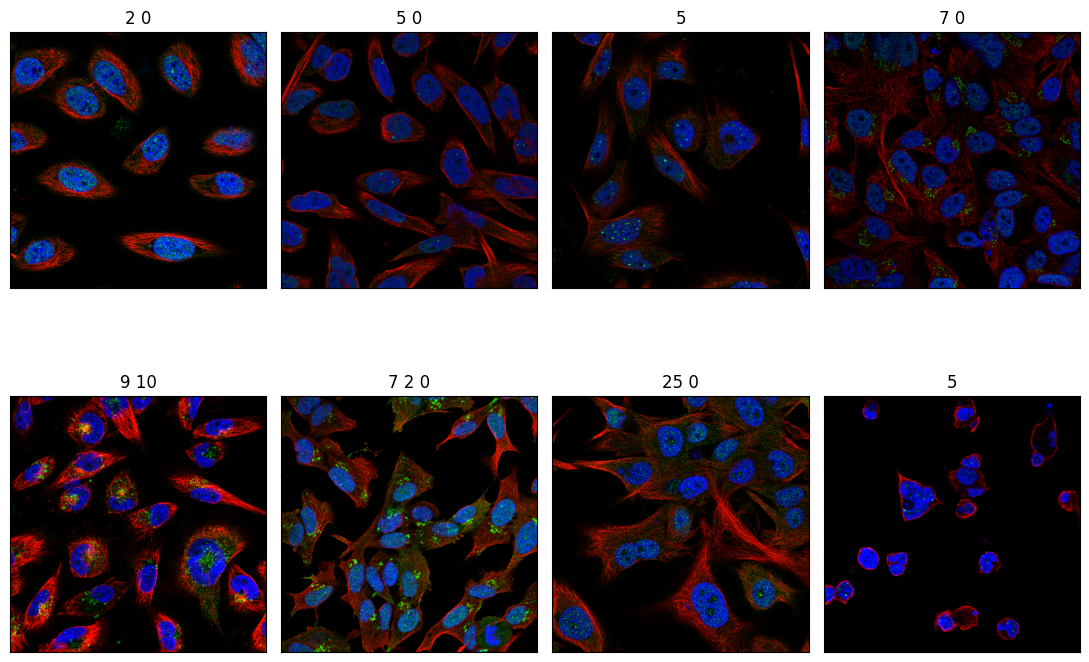

In [5]:
# Looking at some images
import random
fig, axes = plt.subplots(2, 4, figsize=(11, 11))
for i in range(2):
  for j in range (4):
    id_x = random.randint(0,df.shape[0])
    row = df.iloc[id_x,:]
    p = row.complete_path
    red_part = np.array(Image.open( p + '_red.png'))
    green_part = np.array(Image.open( p + '_green.png'))
    blue_part = np.array(Image.open( p + '_blue.png'))

    # Putting the RGB parts together to get the actual img
    img = np.dstack((red_part, green_part, blue_part))
    axes[i][j].imshow(img)
    axes[i][j].set_title(row.Target)

    # Clean it up
    axes[i][j].set_xticks([])
    axes[i][j].set_yticks([])

    fig.tight_layout()
    fig.show()

In [6]:
# Split for train and val data (80/20)
from sklearn.model_selection import train_test_split
df = df.sample(frac=1, random_state = 42).reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, val_df.shape

((24857, 3), (6215, 3))

In [7]:
# Size of images. I will choose to work with the original sizes
img_width, img_height = 512, 512
# Params: path: String, target: Array
# This method is to help construct the training set
def loadnp_data(path, target):
    # Load individual channels
    red = tf.squeeze(tf.image.decode_png(tf.io.read_file(path + '_red.png'), channels=1), [2])
    green = tf.squeeze(tf.image.decode_png(tf.io.read_file(path + '_green.png'), channels=1), [2])
    blue = tf.squeeze(tf.image.decode_png(tf.io.read_file(path + '_blue.png'), channels=1), [2])

    # Stack them together to create the 3-channel image
    img = tf.stack([red, green, blue], axis=2)

    return img, target

In [8]:
# Params: Dataframe
# Purpose: To make the labels match up to images cleaner. Matrices/Arrays instead of strings
def structure_data(df):
  # Complete paths
  paths = []
  # One-hot encoded representation of labels
  labels = []
  for _, row in df.iterrows():
    paths.append(row.complete_path)
    # As stated in kaggle, we have a total of 28 possible labels
    target_matrix = np.zeros(28)
    for target in row.Target.split(' '):
      target_matrix[int(target)] = 1
    labels.append(target_matrix)
  return np.array(paths), np.array(labels)

In [9]:
# Structure Our Data
train_path, train_target = structure_data(train_df)
val_path, val_target = structure_data(val_df)

train_path[0], train_target[0]

('/kaggle/input/human-protein-atlas-image-classification//train/110db2ca-bbc8-11e8-b2bc-ac1f6b6435d0',
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))

In [10]:
train_path.shape, train_target.shape, val_path.shape, val_target.shape

((24857,), (24857, 28), (6215,), (6215, 28))

In [11]:
# Smashing it back together in the new format | path, labels
train = tf.data.Dataset.from_tensor_slices((train_path, train_target))
val = tf.data.Dataset.from_tensor_slices((val_path, val_target))
for item in train.take(5):
    print(item)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/human-protein-atlas-image-classification//train/110db2ca-bbc8-11e8-b2bc-ac1f6b6435d0'>, <tf.Tensor: shape=(28,), dtype=float64, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/human-protein-atlas-image-classification//train/bd6301e8-bb9a-11e8-b2b9-ac1f6b6435d0'>, <tf.Tensor: shape=(28,), dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/human-protein-atlas-image-classification//train/180b408c-bbb0-11e8-b2ba-ac1f6b6435d0'>, <tf.Tensor: shape=(28,), dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>)
(<tf.Tensor: shape=(), dtype=st

In [12]:
# Dynamically decide the optimal number of parallel threads
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Mapping the full RGB image to labels instead of paths in the data files | images, labels
train_data = train.map(loadnp_data, num_parallel_calls=AUTOTUNE)
val_data = val.map(loadnp_data, num_parallel_calls=AUTOTUNE)

In [13]:
# Image Augmentation to avoid overfitting
def image_augment(img, target):
    #
    img = tf.image.random_contrast(img, lower=0.3, upper=2.0)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, target

train_data_aug = train_data.map(image_augment, num_parallel_calls=AUTOTUNE)
val_data_aug = val_data.map(image_augment, num_parallel_calls=AUTOTUNE)

In [14]:
def resize_image(img, target):
    img = tf.image.resize(img, [512, 512])  # Resize to 512x512
    return img, target
train_data_aug = train_data_aug.map(resize_image, num_parallel_calls=AUTOTUNE)
val_data_aug = val_data_aug.map(resize_image, num_parallel_calls=AUTOTUNE)
# Resizing is not necessary here, but I would like to see the spec looking good.
train_data_aug.element_spec, val_data_aug.element_spec

((TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(28,), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(28,), dtype=tf.float64, name=None)))

In [15]:
train_data_batches = train_data_aug.batch(16).prefetch(buffer_size=AUTOTUNE)
val_data_batches = val_data_aug.batch(16).prefetch(buffer_size=AUTOTUNE)

In [16]:
#Training | A pretrained ResNet50 model
# The model was trained on the ImageNet dataset
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))


x = base_model.output
# For the final convolution layer of the ResNet50
x = GlobalAveragePooling2D()(x)
# Drop 50% of neurons to prevent overfitting
x = Dropout(0.5)(x)
# To solve the vanishing gradient issue
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# 28 neurons as we have a total of 28 features
output = Dense(28, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
# Learning rate at 1e-4 to avoid getting rid of the general uses of the pretrained model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,653,212 (94.04 MB)

 Trainable params: 24,599,068 (93.84 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [18]:
# Step 1: Train with frozen base model
base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
first_history = model.fit(train_data_batches, steps_per_epoch = 150, validation_data=val_data_batches, epochs=5)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 97s 559ms/step - binary_accuracy: 0.5811 - loss: 0.8140 - val_binary_accuracy: 0.9472 - val_loss: 0.1925
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 455ms/step - binary_accuracy: 0.9364 - loss: 0.2210 - val_binary_accuracy: 0.9475 - val_loss: 0.1651
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 458ms/step - binary_accuracy: 0.9444 - loss: 0.1786 - val_binary_accuracy: 0.9485 - val_loss: 0.1587
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 73s 487ms/step - binary_accuracy: 0.9426 - loss: 0.1782 - val_binary_accuracy: 0.9456 - val_loss: 0.1657
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 70s 469ms/step - binary_accuracy: 0.9455 - loss: 0.1687 - val_binary_accuracy: 0.9487 - val_loss: 0.1548


In [19]:
# Step 2: Unfreeze and fine-tune
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])
final_history = model.fit(train_data_batches, steps_per_epoch = 150, validation_data=val_data_batches, epochs=10)

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 158s 663ms/step - binary_accuracy: 0.9446 - loss: 0.1729 - val_binary_accuracy: 0.9497 - val_loss: 0.1626
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 91s 606ms/step - binary_accuracy: 0.9496 - loss: 0.1555 - val_binary_accuracy: 0.9394 - val_loss: 0.2002
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 90s 603ms/step - binary_accuracy: 0.9507 - loss: 0.1458 - val_binary_accuracy: 0.9534 - val_loss: 0.1352
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 90s 604ms/step - binary_accuracy: 0.9521 - loss: 0.1421 - val_binary_accuracy: 0.9528 - val_loss: 0.1359
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 92s 616ms/step - binary_accuracy: 0.9544 - loss: 0.1354 - val_binary_accuracy: 0.9551 - val_loss: 0.1322
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 90s 605ms/step - binary_accuracy: 0.9560 - loss: 0.1320 - val_binary_accuracy: 0.9560 - val_loss: 0.1286
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 865ms/step - binary_accuracy: 0.9552 - loss: 0.1282 - val_binary_accuracy: 0.9568 - 